##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to load and preprocess an image dataset in three ways. First, you will use high-level Keras preprocessing [utilities](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) and [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) to read a directory of images on disk. Next, you will write your own input pipeline from scratch using [tf.data](https://www.tensorflow.org/guide/data). Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
print(tf.__version__)

2.4.0


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains 5 sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available. There are 3670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

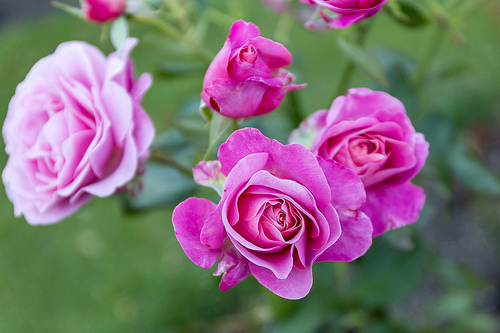

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

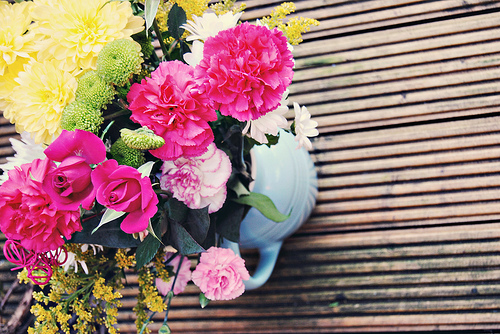

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load using keras.preprocessing

Let's load these images off disk using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

Note: The Keras Preprocesing utilities and layers introduced in this section are currently experimental and may change.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first 9 images from the training dataset.

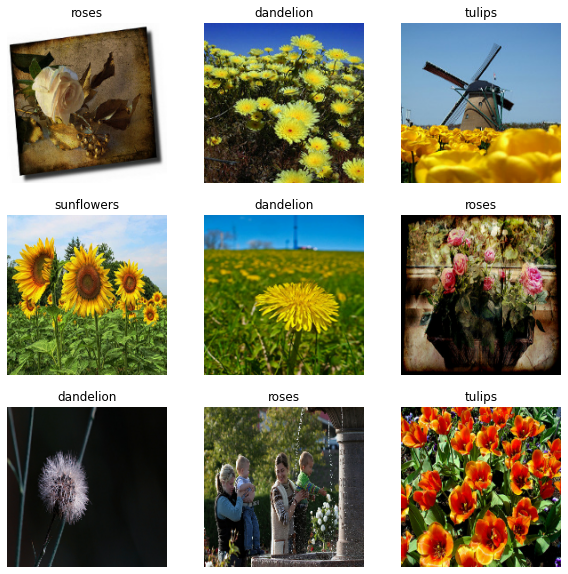

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 


Note: you can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [14]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


Or, you can include the layer inside your model definition to simplify deployment. We will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `Rescaling(1./127.5, offset=-1)`

Note: we previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer instead.


### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, we will show how to train a simple model using the datasets we just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit this [tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [17]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: we will only train for a few epochs so this tutorial runs quickly. 

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 4:03 - loss: 1.6148 - accuracy: 0.1562

 3/92 [..............................] - ETA: 3s - loss: 1.7832 - accuracy: 0.2153  

 4/92 [>.............................] - ETA: 4s - loss: 1.7672 - accuracy: 0.2357

 5/92 [>.............................] - ETA: 4s - loss: 1.7562 - accuracy: 0.2435

 6/92 [>.............................] - ETA: 4s - loss: 1.7497 - accuracy: 0.2516

 7/92 [=>............................] - ETA: 4s - loss: 1.7420 - accuracy: 0.2584

 8/92 [=>............................] - ETA: 4s - loss: 1.7347 - accuracy: 0.2637

 9/92 [=>............................] - ETA: 4s - loss: 1.7275 - accuracy: 0.2675

10/92 [==>...........................] - ETA: 4s - loss: 1.7208 - accuracy: 0.2695

11/92 [==>...........................] - ETA: 4s - loss: 1.7143 - accuracy: 0.2724

12/92 [==>...........................] - ETA: 4s - loss: 1.7076 - accuracy: 0.2755

13/92 [===>..........................] - ETA: 4s - loss: 1.7013 - accuracy: 0.2786

14/92 [===>..........................] - ETA: 4s - loss: 1.6947 - accuracy: 0.2823

16/92 [====>.........................] - ETA: 4s - loss: 1.6813 - accuracy: 0.2895

18/92 [====>.........................] - ETA: 4s - loss: 1.6686 - accuracy: 0.2957

19/92 [=====>........................] - ETA: 4s - loss: 1.6624 - accuracy: 0.2985

20/92 [=====>........................] - ETA: 4s - loss: 1.6566 - accuracy: 0.3010

21/92 [=====>........................] - ETA: 3s - loss: 1.6509 - accuracy: 0.3033

22/92 [======>.......................] - ETA: 3s - loss: 1.6449 - accuracy: 0.3054

23/92 [======>.......................] - ETA: 3s - loss: 1.6391 - accuracy: 0.3074

24/92 [======>.......................] - ETA: 3s - loss: 1.6340 - accuracy: 0.3090

25/92 [=======>......................] - ETA: 3s - loss: 1.6293 - accuracy: 0.3106

26/92 [=======>......................] - ETA: 3s - loss: 1.6246 - accuracy: 0.3120

27/92 [=======>......................] - ETA: 3s - loss: 1.6200 - accuracy: 0.3134

29/92 [========>.....................] - ETA: 3s - loss: 1.6112 - accuracy: 0.3162

30/92 [========>.....................] - ETA: 3s - loss: 1.6071 - accuracy: 0.3175

31/92 [=========>....................] - ETA: 3s - loss: 1.6032 - accuracy: 0.3188

32/92 [=========>....................] - ETA: 3s - loss: 1.5994 - accuracy: 0.3200

34/92 [==========>...................] - ETA: 3s - loss: 1.5915 - accuracy: 0.3227

36/92 [==========>...................] - ETA: 3s - loss: 1.5839 - accuracy: 0.3249

37/92 [===========>..................] - ETA: 3s - loss: 1.5801 - accuracy: 0.3261

38/92 [===========>..................] - ETA: 2s - loss: 1.5764 - accuracy: 0.3273

40/92 [============>.................] - ETA: 2s - loss: 1.5690 - accuracy: 0.3298

41/92 [============>.................] - ETA: 2s - loss: 1.5653 - accuracy: 0.3312

42/92 [============>.................] - ETA: 2s - loss: 1.5616 - accuracy: 0.3326

43/92 [=============>................] - ETA: 2s - loss: 1.5580 - accuracy: 0.3340

44/92 [=============>................] - ETA: 2s - loss: 1.5543 - accuracy: 0.3353

45/92 [=============>................] - ETA: 2s - loss: 1.5509 - accuracy: 0.3366

46/92 [==============>...............] - ETA: 2s - loss: 1.5476 - accuracy: 0.3379

47/92 [==============>...............] - ETA: 2s - loss: 1.5444 - accuracy: 0.3390

48/92 [==============>...............] - ETA: 2s - loss: 1.5414 - accuracy: 0.3402

49/92 [==============>...............] - ETA: 2s - loss: 1.5383 - accuracy: 0.3413

50/92 [===============>..............] - ETA: 2s - loss: 1.5354 - accuracy: 0.3423

51/92 [===============>..............] - ETA: 2s - loss: 1.5325 - accuracy: 0.3434

52/92 [===============>..............] - ETA: 2s - loss: 1.5297 - accuracy: 0.3445

53/92 [================>.............] - ETA: 2s - loss: 1.5269 - accuracy: 0.3455

55/92 [================>.............] - ETA: 2s - loss: 1.5215 - accuracy: 0.3476

56/92 [=================>............] - ETA: 1s - loss: 1.5188 - accuracy: 0.3486

58/92 [=================>............] - ETA: 1s - loss: 1.5137 - accuracy: 0.3506

59/92 [==================>...........] - ETA: 1s - loss: 1.5112 - accuracy: 0.3515

60/92 [==================>...........] - ETA: 1s - loss: 1.5088 - accuracy: 0.3525

61/92 [==================>...........] - ETA: 1s - loss: 1.5063 - accuracy: 0.3535

62/92 [===================>..........] - ETA: 1s - loss: 1.5038 - accuracy: 0.3545

64/92 [===================>..........] - ETA: 1s - loss: 1.4988 - accuracy: 0.3566

65/92 [====================>.........] - ETA: 1s - loss: 1.4964 - accuracy: 0.3576

66/92 [====================>.........] - ETA: 1s - loss: 1.4940 - accuracy: 0.3585

68/92 [=====================>........] - ETA: 1s - loss: 1.4892 - accuracy: 0.3605

69/92 [=====================>........] - ETA: 1s - loss: 1.4869 - accuracy: 0.3615

70/92 [=====================>........] - ETA: 1s - loss: 1.4847 - accuracy: 0.3624

71/92 [======================>.......] - ETA: 1s - loss: 1.4824 - accuracy: 0.3634

72/92 [======================>.......] - ETA: 1s - loss: 1.4801 - accuracy: 0.3645

73/92 [======================>.......] - ETA: 1s - loss: 1.4778 - accuracy: 0.3655

74/92 [=======================>......] - ETA: 0s - loss: 1.4756 - accuracy: 0.3665

75/92 [=======================>......] - ETA: 0s - loss: 1.4733 - accuracy: 0.3675

76/92 [=======================>......] - ETA: 0s - loss: 1.4712 - accuracy: 0.3684

77/92 [========================>.....] - ETA: 0s - loss: 1.4691 - accuracy: 0.3694

78/92 [========================>.....] - ETA: 0s - loss: 1.4669 - accuracy: 0.3704

79/92 [========================>.....] - ETA: 0s - loss: 1.4648 - accuracy: 0.3714

81/92 [=========================>....] - ETA: 0s - loss: 1.4608 - accuracy: 0.3733

82/92 [=========================>....] - ETA: 0s - loss: 1.4588 - accuracy: 0.3742

83/92 [==========================>...] - ETA: 0s - loss: 1.4568 - accuracy: 0.3752

85/92 [==========================>...] - ETA: 0s - loss: 1.4529 - accuracy: 0.3771

90/92 [============================>.] - ETA: 0s - loss: 1.4435 - accuracy: 0.3816

92/92 [==============================] - ETA: 0s - loss: 1.4401 - accuracy: 0.3832

92/92 [==============================] - 9s 70ms/step - loss: 1.4384 - accuracy: 0.3840 - val_loss: 1.0406 - val_accuracy: 0.5913


Epoch 2/3
 1/92 [..............................] - ETA: 0s - loss: 1.0790 - accuracy: 0.6250

 7/92 [=>............................] - ETA: 0s - loss: 1.0485 - accuracy: 0.6008

12/92 [==>...........................] - ETA: 0s - loss: 1.0453 - accuracy: 0.5987

17/92 [====>.........................] - ETA: 0s - loss: 1.0399 - accuracy: 0.5968

23/92 [======>.......................] - ETA: 0s - loss: 1.0365 - accuracy: 0.5951

29/92 [========>.....................] - ETA: 0s - loss: 1.0328 - accuracy: 0.5969

35/92 [==========>...................] - ETA: 0s - loss: 1.0290 - accuracy: 0.5988

41/92 [============>.................] - ETA: 0s - loss: 1.0248 - accuracy: 0.5997

46/92 [==============>...............] - ETA: 0s - loss: 1.0216 - accuracy: 0.6005

51/92 [===============>..............] - ETA: 0s - loss: 1.0202 - accuracy: 0.6008

56/92 [=================>............] - ETA: 0s - loss: 1.0195 - accuracy: 0.6006

61/92 [==================>...........] - ETA: 0s - loss: 1.0191 - accuracy: 0.6003

67/92 [====================>.........] - ETA: 0s - loss: 1.0182 - accuracy: 0.6003

73/92 [======================>.......] - ETA: 0s - loss: 1.0168 - accuracy: 0.6005

78/92 [========================>.....] - ETA: 0s - loss: 1.0154 - accuracy: 0.6009

84/92 [==========================>...] - ETA: 0s - loss: 1.0138 - accuracy: 0.6014

90/92 [============================>.] - ETA: 0s - loss: 1.0122 - accuracy: 0.6019

92/92 [==============================] - 1s 12ms/step - loss: 1.0117 - accuracy: 0.6021 - val_loss: 0.9834 - val_accuracy: 0.6158


Epoch 3/3


 1/92 [..............................] - ETA: 0s - loss: 1.0154 - accuracy: 0.5312

 7/92 [=>............................] - ETA: 0s - loss: 0.9542 - accuracy: 0.6149

13/92 [===>..........................] - ETA: 0s - loss: 0.9186 - accuracy: 0.6460

19/92 [=====>........................] - ETA: 0s - loss: 0.9057 - accuracy: 0.6551

25/92 [=======>......................] - ETA: 0s - loss: 0.8934 - accuracy: 0.6611

31/92 [=========>....................] - ETA: 0s - loss: 0.8836 - accuracy: 0.6666

36/92 [==========>...................] - ETA: 0s - loss: 0.8772 - accuracy: 0.6700

42/92 [============>.................] - ETA: 0s - loss: 0.8710 - accuracy: 0.6722

48/92 [==============>...............] - ETA: 0s - loss: 0.8664 - accuracy: 0.6733

54/92 [================>.............] - ETA: 0s - loss: 0.8641 - accuracy: 0.6733

60/92 [==================>...........] - ETA: 0s - loss: 0.8628 - accuracy: 0.6731

66/92 [====================>.........] - ETA: 0s - loss: 0.8615 - accuracy: 0.6732

72/92 [======================>.......] - ETA: 0s - loss: 0.8600 - accuracy: 0.6734

78/92 [========================>.....] - ETA: 0s - loss: 0.8581 - accuracy: 0.6739

84/92 [==========================>...] - ETA: 0s - loss: 0.8563 - accuracy: 0.6743

90/92 [============================>.] - ETA: 0s - loss: 0.8546 - accuracy: 0.6747

92/92 [==============================] - 1s 12ms/step - loss: 0.8540 - accuracy: 0.6748 - val_loss: 0.9012 - val_accuracy: 0.6553


Note: you can also write a custom training loop instead of using `model.fit`. To learn more, visit this [tutorial](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).

You may notice the validation accuracy is low to the compared to the training accuracy, indicating our model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

The above keras.preprocessing utilities are a convenient way to create a `tf.data.Dataset` from a directory of images. For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the zip we downloaded earlier.

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/tulips/8733586143_3139db6e9e_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/14523675369_97c31d0b5b.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/16716172029_2166d8717f_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/4186808407_06688641e2_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/roses/3667366832_7a8017c528_n.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into train and validation:

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can see the length of each dataset as follows:

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [25]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, see the [Input Pipeline Performance](../../guide/performance/datasets) guide.

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously.

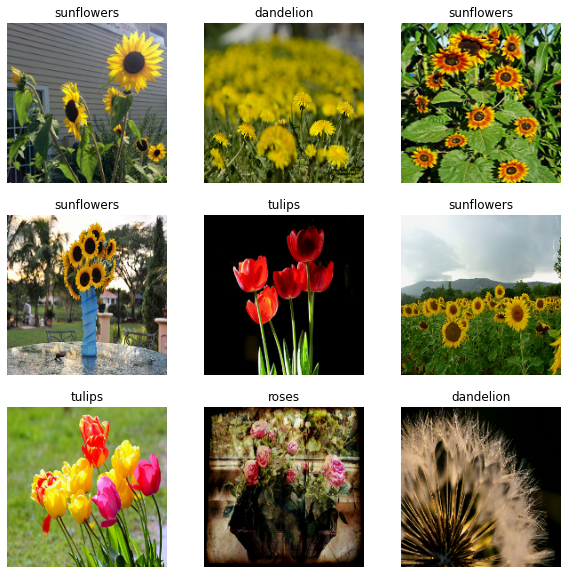

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by the `keras.preprocessing` above. You can continue training the model with it. As before, we will train for just a few epochs to keep the running time short.

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 50s - loss: 0.5570 - accuracy: 0.8125

 5/92 [>.............................] - ETA: 1s - loss: 0.6900 - accuracy: 0.7375 

 9/92 [=>............................] - ETA: 1s - loss: 0.8185 - accuracy: 0.6979

13/92 [===>..........................] - ETA: 1s - loss: 0.7992 - accuracy: 0.7091

17/92 [====>.........................] - ETA: 1s - loss: 0.7659 - accuracy: 0.7224

21/92 [=====>........................] - ETA: 1s - loss: 0.7720 - accuracy: 0.7202

25/92 [=======>......................] - ETA: 0s - loss: 0.7503 - accuracy: 0.7262

29/92 [========>.....................] - ETA: 0s - loss: 0.7285 - accuracy: 0.7338

33/92 [=========>....................] - ETA: 0s - loss: 0.7192 - accuracy: 0.7415

37/92 [===========>..................] - ETA: 0s - loss: 0.7228 - accuracy: 0.7424

41/92 [============>.................] - ETA: 0s - loss: 0.7147 - accuracy: 0.7409

45/92 [=============>................] - ETA: 0s - loss: 0.7062 - accuracy: 0.7444

49/92 [==============>...............] - ETA: 0s - loss: 0.7080 - accuracy: 0.7423

53/92 [================>.............] - ETA: 0s - loss: 0.7039 - accuracy: 0.7465

57/92 [=================>............] - ETA: 0s - loss: 0.7027 - accuracy: 0.7434

61/92 [==================>...........] - ETA: 0s - loss: 0.7147 - accuracy: 0.7423

66/92 [====================>.........] - ETA: 0s - loss: 0.7147 - accuracy: 0.7405

71/92 [======================>.......] - ETA: 0s - loss: 0.7223 - accuracy: 0.7359

76/92 [=======================>......] - ETA: 0s - loss: 0.7289 - accuracy: 0.7327

81/92 [=========================>....] - ETA: 0s - loss: 0.7313 - accuracy: 0.7307

86/92 [===========================>..] - ETA: 0s - loss: 0.7300 - accuracy: 0.7286

91/92 [============================>.] - ETA: 0s - loss: 0.7252 - accuracy: 0.7294

92/92 [==============================] - 2s 20ms/step - loss: 0.7249 - accuracy: 0.7296 - val_loss: 0.6796 - val_accuracy: 0.7466


Epoch 2/3
 1/92 [..............................] - ETA: 1s - loss: 0.5101 - accuracy: 0.8750

 6/92 [>.............................] - ETA: 0s - loss: 0.5145 - accuracy: 0.8281

11/92 [==>...........................] - ETA: 0s - loss: 0.5026 - accuracy: 0.8324

16/92 [====>.........................] - ETA: 0s - loss: 0.4868 - accuracy: 0.8301

21/92 [=====>........................] - ETA: 0s - loss: 0.5050 - accuracy: 0.8229

26/92 [=======>......................] - ETA: 0s - loss: 0.5008 - accuracy: 0.8233

31/92 [=========>....................] - ETA: 0s - loss: 0.5089 - accuracy: 0.8175

36/92 [==========>...................] - ETA: 0s - loss: 0.5203 - accuracy: 0.8090

41/92 [============>.................] - ETA: 0s - loss: 0.5119 - accuracy: 0.8133

46/92 [==============>...............] - ETA: 0s - loss: 0.5131 - accuracy: 0.8125

51/92 [===============>..............] - ETA: 0s - loss: 0.5137 - accuracy: 0.8125

56/92 [=================>............] - ETA: 0s - loss: 0.5135 - accuracy: 0.8125

61/92 [==================>...........] - ETA: 0s - loss: 0.5092 - accuracy: 0.8145

66/92 [====================>.........] - ETA: 0s - loss: 0.5102 - accuracy: 0.8139

71/92 [======================>.......] - ETA: 0s - loss: 0.5117 - accuracy: 0.8125

76/92 [=======================>......] - ETA: 0s - loss: 0.5172 - accuracy: 0.8117

81/92 [=========================>....] - ETA: 0s - loss: 0.5190 - accuracy: 0.8098

86/92 [===========================>..] - ETA: 0s - loss: 0.5190 - accuracy: 0.8070

91/92 [============================>.] - ETA: 0s - loss: 0.5226 - accuracy: 0.8060

92/92 [==============================] - 1s 12ms/step - loss: 0.5239 - accuracy: 0.8055 - val_loss: 0.6280 - val_accuracy: 0.7793


Epoch 3/3
 1/92 [..............................] - ETA: 1s - loss: 0.4499 - accuracy: 0.8438

 6/92 [>.............................] - ETA: 0s - loss: 0.3501 - accuracy: 0.9062

11/92 [==>...........................] - ETA: 0s - loss: 0.4387 - accuracy: 0.8665

16/92 [====>.........................] - ETA: 0s - loss: 0.4237 - accuracy: 0.8750

21/92 [=====>........................] - ETA: 0s - loss: 0.4153 - accuracy: 0.8720

26/92 [=======>......................] - ETA: 0s - loss: 0.3945 - accuracy: 0.8786

31/92 [=========>....................] - ETA: 0s - loss: 0.3751 - accuracy: 0.8851

36/92 [==========>...................] - ETA: 0s - loss: 0.3610 - accuracy: 0.8889

41/92 [============>.................] - ETA: 0s - loss: 0.3505 - accuracy: 0.8918

46/92 [==============>...............] - ETA: 0s - loss: 0.3557 - accuracy: 0.8899

51/92 [===============>..............] - ETA: 0s - loss: 0.3470 - accuracy: 0.8903

56/92 [=================>............] - ETA: 0s - loss: 0.3547 - accuracy: 0.8878

61/92 [==================>...........] - ETA: 0s - loss: 0.3520 - accuracy: 0.8883

66/92 [====================>.........] - ETA: 0s - loss: 0.3522 - accuracy: 0.8887

71/92 [======================>.......] - ETA: 0s - loss: 0.3526 - accuracy: 0.8869

76/92 [=======================>......] - ETA: 0s - loss: 0.3525 - accuracy: 0.8873

81/92 [=========================>....] - ETA: 0s - loss: 0.3524 - accuracy: 0.8858

86/92 [===========================>..] - ETA: 0s - loss: 0.3561 - accuracy: 0.8826

91/92 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8802

92/92 [==============================] - 1s 12ms/step - loss: 0.3618 - accuracy: 0.8801 - val_loss: 0.6565 - val_accuracy: 0.7766


## Using TensorFlow Datasets

So far, this tutorial has focused on loading data off disk. You can also find a dataset to use by exploring the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at [TensorFlow Datasets](https://www.tensorflow.org/datasets). As you have previously loaded the Flowers dataset off disk, let's see how to import it with TensorFlow Datasets. 

Download the flowers [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) using TensorFlow Datasets.

In [33]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes.

In [34]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


 Retrieve an image from the dataset.

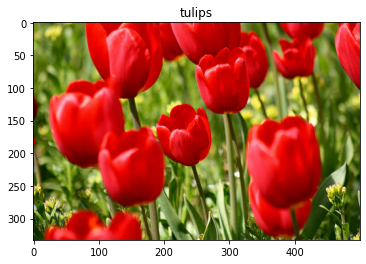

In [35]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

As before, remember to batch, shuffle, and configure each dataset for performance.

In [36]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

You can find a complete example of working with the flowers dataset and TensorFlow Datasets by visiting the [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) tutorial.

## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using tf.data. Finally, you learned how to download a dataset from TensorFlow Datasets. As a next step, you can learn how to add data augmentation by visiting this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation). To learn more about tf.data, you can visit this [guide](https://www.tensorflow.org/guide/data).